## In this script we experiment with a single-stage energy trading MPC. Pump and gate actions are still multi-stage. So we have 1 to x hours of IDM trading, and then x to N hours of DAM trading/preparation.

In [2]:
from utils.scenario_gen import *
from utils.trees import *
from utils.clustering import *
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize as minimize_pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
from py_banshee.prediction import inference
from py_banshee.rankcorr import bn_rankcorr

In [4]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import logging
import copy

In [5]:
datapath = Path(Path().resolve()).parent.parent.parent / 'data'
scenario_path = Path(Path().resolve()).parent.parent.parent / 'data' / 'forecast data' / 'Scenarios'
market_datapath = datapath / 'market data'
wl_datapath = datapath / 'waterlevel data'
wb_datapath = datapath / 'waterboard data'
ark_datapath = datapath / 'ark data'

In [22]:
scenario_params = {
    'DAM': {
        'n': 5,
        'method': 'energy'
    },
    'IDM':{
        'n_init': 100,
        'n': 5,
        'method': 'energy',
    },
    'wl': {
        'n': 5,
        'method': 'energy'
    },
    'discharge': {
        'n': 5,
        'n_wb': 5,
        'method': 'energy'
    }
}

In [23]:
class ObservationData():
    """
    Class for generating observation data for the optimization problem.
    """
    def __init__(self, market_datapath, wl_datapath, wb_datapath, ark_datapath):
        # Load the DAM data
        self.dam = pd.read_pickle(market_datapath / 'DAM_prices.pkl').loc[:, ['NL']].dropna()
        self.dam.index = self.dam.index.tz_convert('Europe/Amsterdam')
        self.dam.columns = ['DAM']

        # Load the IDM data
        self.idm = pd.read_pickle(market_datapath / 'NL_ID.pickle').loc[:, ['ID3']].astype(float)
        self.idm.index = self.idm.index.tz_convert('Europe/Amsterdam')
        self.idm.columns = ['IDM']

        # Load the waterlevel data
        self.wl = pd.read_csv(wl_datapath / 'IJmuiden Noordersluis.csv', index_col=0, parse_dates=True)
        self.wl.index = self.wl.index.tz_convert('Europe/Amsterdam')
        self.wl.columns = ['WL']
        self.wl.replace(to_replace=self.wl.max(), value=np.nan, inplace=True)
        self.wl = self.wl / 100 # cm+NAP to m+NAP
        
        self.wl_hourly = self.wl.copy().resample('1H').mean()

        # Load the waterboard data
        self.waterboards = ['HHNK', 'HDSR', 'Waternet', 'Rijnland']
        self.waterboard_discharge = {
            'HHNK': pd.read_csv(wb_datapath / 'Q_HHNK.csv', index_col=0, parse_dates=True).astype(float).resample('1H').mean(),
            'HDSR': pd.read_csv(wb_datapath / 'Q_HDSR.csv', index_col=0, parse_dates=True).astype(float).resample('1H').mean(),
            'Waternet': pd.read_csv(wb_datapath / 'Q_Waternet.csv', index_col=0, parse_dates=True).astype(float).resample('1H').mean(),
            'Rijnland': pd.read_csv(wb_datapath / 'Q_Rijnland.csv', index_col=0, parse_dates=True).astype(float).resample('1H').mean(),
        }

        # Make a new dataframe with the sum
        self.discharge = pd.concat([
            self.waterboard_discharge[wb].sum(axis=1) for wb in self.waterboards
        ], axis=1)
        self.discharge.loc[:, 'Q'] = self.discharge.sum(axis=1)
        self.discharge = self.discharge.loc[:, ['Q']]
        self.discharge.index = self.discharge.index.tz_convert('Europe/Amsterdam')

        # Load ARK discharge data measured in Maarssen
        self.ark = pd.read_pickle(ark_datapath / 'Q_ark.pkl')

        # Equalize the indices
        # self._equalize_indices()

    def get_observation_data(self, start, end):
        """
        Get the observation data for the optimization problem.
        """
        dam = self.dam.loc[start:end, :]
        idm = self.idm.loc[start:end, :]
        wl_hourly = self.wl_hourly.loc[start:end, :]
        discharge = self.discharge.loc[start:end, :]
        ark = self.ark.loc[start:end, :]

        return dam, idm, wl_hourly, discharge, ark
    
    def get_observation_data_single(self, var, start, end):
        """
        Get the observation data for a single variable.
        """
        if var == 'DAM':
            return self.dam.loc[start:end, :]
        elif var == 'IDM':
            return self.idm.loc[start:end, :]
        elif var == 'WL':
            return self.wl.loc[start:end, :]
        elif var == 'WL_hourly':
            return self.wl_hourly.loc[start:end, :]
        elif var == 'discharge':
            return self.discharge.loc[start:end, :]
        elif var == 'ARK':
            return self.ark.loc[start:end, :]
        else:
            raise ValueError('Variable not recognized.')
        
    def _equalize_indices(self, t_min=None, t_max=None):
        """
        Equalize the indices of the different observation dataframes.
        """
        if t_min is None:
            t_min = max([df.index.min() for df in [self.dam, self.idm, self.wl, self.discharge, self.ark]])
        if t_max is None:
            t_max = min([df.index.max() for df in [self.dam, self.idm, self.wl, self.discharge, self.ark]])

        self.dam = self.dam.loc[t_min:t_max, :]
        self.idm = self.idm.loc[t_min:t_max, :]
        self.wl = self.wl.loc[t_min:t_max, :]
        self.discharge = self.discharge.loc[t_min:t_max, :]
        self.ark = self.ark.loc[t_min:t_max, :]

In [24]:
class IDMScenarios():
    """
    Class for generating scenarios for IDM.
    """
    def __init__(self, obs_dataclass, n_init, n, method, n_prices=24+1, normalize_idm=True, cluster=False, cluster_method='energy'):
        self.n_init = n_init
        self.n = n
        self.method = method
        self.dam = obs_dataclass.dam
        self.idm = obs_dataclass.idm
        self.n_prices = n_prices
        self.normalize_idm = normalize_idm
        self.bn_structure = None
        self.cluster = cluster
        self.cluster_method = cluster_method

        self._prep_market_data()

    def _prep_market_data(self):
        # Group the data by day
        self.dam_grouped = pd.DataFrame(index=self.dam.loc[self.dam.index.hour==0].index, columns=[f'DAM{i}' for i in range(1, self.n_prices)])
        self.idm_grouped = pd.DataFrame(index=self.idm.loc[self.idm.index.hour==0].index, columns=[f'IDM{i}' for i in range(1, self.n_prices)])
        
        # Shift the index by one hour -> future IDM and DAM prices
        # DAM0 data is the last DAM price of the previous day
        # DAM0 = 2300 - 00:00, DAM1 = 00:00 - 01:00, DAM2 = 01:00 - 02:00, etc.
        for i in range(self.n_prices):
            self.dam_grouped.loc[:, f'DAM{i}'] = self.dam.shift(-(i-1)).loc[self.dam.index.hour==0, 'DAM']
        for i in range(self.n_prices):
            self.idm_grouped.loc[:, f'IDM{i}'] = self.idm.shift(-(i-1)).loc[self.idm.index.hour==0, 'IDM']
        
    def _prep_bn_data(self, t_min=None, t_max=None):
        """
        Prepare the data for the Bayesian network.
        """
        # Equalize the indices
        if t_min is None:
            t_min = max([df.index.min() for df in [self.dam_grouped, self.idm_grouped]])
        if t_max is None:
            t_max = min([df.index.max() for df in [self.dam_grouped, self.idm_grouped]])

        dam_grouped = self.dam_grouped.loc[t_min:t_max, :].copy()
        idm_grouped = self.idm_grouped.loc[t_min:t_max, :].copy()

        self.bn_data = pd.concat([dam_grouped, idm_grouped], axis=1).dropna()
        self._normalize_bn_data()
    
    def _normalize_bn_data(self, inplace=True, bn_data=None, mask=True):
        """
        Normalize the data by dividing the IDM prices by the DAM prices
        """
        if inplace:
            bn_data = self.bn_data
        else:
            if bn_data is None:
                raise ValueError('If inplace is False, bn_date must be specified.')

        if self.normalize_idm:
            for h in range(self.n_prices):
                bn_data[f'IDM{h}'] = bn_data[f'IDM{h}'].values.flatten() / bn_data[f'DAM{h}'].values.flatten()
        if mask:
            # Mask all the values of the scaled IDM to remove outliers
            min_val = bn_data.loc[:, [f'IDM{h}' for h in range(self.n_prices)]].min()
            min_val = min_val.mean() - 4 * min_val.std()
            max_val = bn_data.loc[:, [f'IDM{h}' for h in range(self.n_prices)]].max()
            max_val = max_val.mean() + 4 * max_val.std()

            for h in range(self.n_prices):
                bn_data.loc[bn_data[f'IDM{h}'] < min_val, f'IDM{h}'] = min_val
                bn_data.loc[bn_data[f'IDM{h}'] > max_val, f'IDM{h}'] = max_val

        if inplace:
            self.bn_data = bn_data

    def _cluster_bn_data(self, data, method='energy'):
        """
        Cluster the data.
        """
        clusterer = ReduceForward(
            x=data,
            cdn=self.n,
            w=None,
            dist=self.cluster_method,
            p=1,
            parallel=False,
            verbose=False
        )
        clusterer.reduce_forward()
        return clusterer.clusters.astype(float)
                
    def update_bn(self, t_min=None, t_max=None):
        """
        Update the Bayesian network.
        """
        self._prep_bn_data(t_min=t_min, t_max=t_max)
        self.bn = IDM_BN(
            bn_data=self.bn_data,
            bn_structure=None,
            normalize_idm=True,
            bn_data_is_normalized=True,
            pred_hor=self.n_prices-1,
            mask_factor=4,
            mask_method='std',
            mask_by_hour=True
        )

    def _mask_inputs(self, dam_scenario, idm_observation):
        """
        Mask the inputs of the Bayesian network so that any values outside of the range are set to the minimum or maximum value.
        """
        # Mask the DAM scenario
        for h in range(len(dam_scenario)):
            if dam_scenario[h] < self.bn_data[f'DAM{h}'].min():
                dam_scenario[h] = self.bn_data[f'DAM{h}'].min()
            elif dam_scenario[h] > self.bn_data[f'DAM{h}'].max():
                dam_scenario[h] = self.bn_data[f'DAM{h}'].max()
        
        # Mask the IDM observation
        for h in range(len(idm_observation)):
            if idm_observation[h] < self.bn_data[f'IDM{h}'].min():
                idm_observation[h] = self.bn_data[f'IDM{h}'].min()
            elif idm_observation[h] > self.bn_data[f'IDM{h}'].max():
                idm_observation[h] = self.bn_data[f'IDM{h}'].max()

        return dam_scenario, idm_observation
                
    def __call__(self, dam_scenario, idm_observations, n_samples=10, is_normalized=False):
        # dam_scenario, idm_observations = self._mask_inputs(dam_scenario, idm_observations)
        scens = self.bn.infer_idm(dam_scenario, idm_observations, n_samples=n_samples, is_normalized=is_normalized)
        if not self.cluster:
            return scens
        else:
            return self._cluster_bn_data(scens, method=self.cluster_method)
    

In [25]:
class ScenarioData():
    """
    Class to keep all scenario data for the optimization problem.
    """
    def __init__(self, scenario_params, constrain_tree_complexity=True, complexity_reduction=0.8):
        self.scenario_params = scenario_params
        self.wl = pd.read_pickle(scenario_path / f'wl_{scenario_params["wl"]["method"]}_{scenario_params["wl"]["n"]}.pkl').dropna()
        self.wl.index = pd.MultiIndex.from_arrays([self.wl.index.droplevel(1).tz_convert('Europe/Amsterdam'), self.wl.index.droplevel(0)], names=['date', 'scenario'])
        self.discharge = pd.read_pickle(scenario_path / f'discharge_{scenario_params["discharge"]["method"]}_{scenario_params["discharge"]["n_wb"]}_{scenario_params["discharge"]["n"]}.pkl').dropna()
        self.discharge.index = pd.MultiIndex.from_arrays([self.discharge.index.droplevel(1).tz_convert('Europe/Amsterdam'), self.discharge.index.droplevel(0)], names=['date', 'scenario'])
        self.dam = pd.read_pickle(scenario_path / f'DAM_{scenario_params["DAM"]["method"]}_{scenario_params["DAM"]["n"]}.pkl').dropna()
        self.reformat_dam_index()

        # Ensure that all dataframes have the same index
        datemin = max(self.wl.index.min(), self.discharge.index.min(), self.dam.index.min())
        datemax = min(self.wl.index.max(), self.discharge.index.max(), self.dam.index.max())
        self.wl = self.wl.loc[datemin:datemax]
        self.discharge = self.discharge.loc[datemin:datemax]
        self.dam = self.dam.loc[datemin:datemax]

        self.constrain_tree_complexity = constrain_tree_complexity
        self.complexity_reduction = complexity_reduction
        self.idx = pd.IndexSlice
    
    def generate_tree(self, date, varname, scenarios=None):
        if scenarios is None:
            scenarios = self.get_scenarios(date, varname)
            
        scenarios.index = scenarios.index.droplevel(0)
        problem = ScenarioTreeOptimizationProblem(
            scenarios=scenarios,
            n_leafs=len(scenarios.index),
            n_splits=10, # max nr of node-splitting locations
            constrain_complexity=self.constrain_tree_complexity,
            complexity_reduction_factor=self.complexity_reduction,
        )
        algorithm = GA(
            pop_size=30,
            eliminate_duplicates=True,
        )
        # termination = DefaultSingleObjectiveTermination(
        #     n_max_gen=100,
        #     # max_time=30,
        #     period=20,
        # )
        termination = ("time", 10)
        # termination = ("n_gen", 100)
        res = minimize_pymoo(
            problem=problem,
            algorithm=algorithm,
            termination=termination,
            seed=1,
            verbose=False,
        )

        node_locations = list(res.X[:problem.n_splits])
        split_sizes = list(res.X[problem.n_splits:])

        node_locations, split_sizes = problem.format_node_split(node_locations, split_sizes)
        
        tc = TreeClusterer(scenarios, verbose=False)
        tc.generate_tree(
            node_locations=node_locations,
            split_sizes=split_sizes,
            method=self.scenario_params[varname]['method'],
        )
        return tc.tree
    
    def get_scenarios(self, date, varname):
        if varname == 'DAM':
            return self.dam.loc[self.idx[date, :], :]
        elif varname == 'wl':
            return self.wl.loc[self.idx[date, :], :]
        elif varname == 'discharge':
            return self.discharge.loc[self.idx[date, :], :]
        else:
            raise ValueError(f'Invalid varname {varname}')
        
    def reformat_dam_index(self):
        dates = self.dam.index.get_level_values(0).unique()
        scenario_nrs = self.dam.index.get_level_values(1).unique()
        dates = dates + pd.DateOffset(hours=1)
        dates = dates.tz_convert('Europe/Amsterdam')
        dates = pd.date_range(dates[0] - pd.DateOffset(hours=1), freq='1D', periods=len(dates))
        self.dam.index = pd.MultiIndex.from_product([dates, scenario_nrs],names=['date', 'scenario'])
        # self.dam.index = pd.MultiIndex.from_arrays([dates, scenario_nrs], names=['date', 'scenario'])

In [26]:
class ClosedLoopSimulation():
    """
    Class for closed-loop simulation of the DR optimization problem.
    """
    def __init__(self, simulation_index, observation_dataclass, scenario_dataclass, idm_scenarioclass, tree_classes=['discharge', 'wl'], simulation_data=None):
        self.obs = observation_dataclass
        self.scenario = scenario_dataclass
        self.idm_scenario = idm_scenarioclass
        self.control_horizon = 48 # hour
        self.simulation_index = simulation_index
        self.idx = pd.IndexSlice

        self.tree_shaped = tree_classes

        # Initialize simulation data
        # This will be the dataframe that contains the performed actions.
        if simulation_data is None: # Start from scratch
            self.simulation_data = pd.DataFrame(
                index=self.simulation_index,
                columns=['E_act', 'E_dam', 'Q_gate', 'Q_pump', 'h_nzk', 'Z_gate', 'Z_pump']
            )
            
            # Start with a full reservoir
            self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), 'h_nzk'] = -0.4

            # Start with initial DAM bid of 0
            mindate = self.simulation_data.index.min()
            idm_index = pd.date_range(mindate, mindate + pd.DateOffset(hours=24-mindate.hour), freq='H')
            self.simulation_data.loc[idm_index, 'E_dam'] = 0

        else:
            self.simulation_data = simulation_data

    def _get_idm_scenarios(self, t_now):
        # Get the current DAM prices (observed) untill the next DAM price
        dam_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), freq='H', periods=25) # 25 because we need the DAM price of the hour before this day as well
        dam_obs = self.obs.get_observation_data_single('DAM', dam_obs_index[0], dam_obs_index[-1])

        # Get the IDM scenarios untill now (observed)
        idm_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), t_now - pd.DateOffset(hours=1), freq='H')
        idm_obs = self.obs.get_observation_data_single('IDM', idm_obs_index[0], idm_obs_index[-1])

        # Get the IDM scenarios untill the DAM (forecast / generated)
        return self.idm_scenario(dam_obs.values.flatten(), idm_obs.values.flatten(), 10)

    def prep_opt_data(self, t_now):
        """
        Prepare the optimization data for the optimization problem.
        This will return the data that is used to calculate the optimal actions.
        So we return:
        - the observation at t_now
        - the IDM scenarios untill the DAM
        - the DAM scenarios
        """

        # Get the observations of the external variables at t_now-1h (so one timestep )
        t_o = t_now - pd.DateOffset(hours=1)
        dam_o, idm_o, wl_hourly_o, discharge_o, ark_o = self.obs.get_observation_data(start=t_o, end=t_o)

        # Get the observations of the discharge at ark, this is a perfect forecast.
        ark_meas = self.obs.get_observation_data_single(var='ARK', start=t_now, end=t_now+pd.DateOffset(hours=self.control_horizon))
        
        # Get the observations of h_nzk at t_now-1h (so one timestep )
        # We need to get the h_nzk at t_now-1h, because we need to know the state of the system to decide control actions
        # So we decide the control action from t_now:t_now+control_horizon
        h_nzk_o = self.simulation_data.loc[t_o, 'h_nzk']

        # Get the IDM scenarios untill the DAM
        idm_scenarios = self._get_idm_scenarios(t_now).astype(float)

        # Get the DAM scenarios for tomorrow -> DA bid and prep
        next_dam_timestep = t_now + pd.DateOffset(hours=24-t_now.hour)
        dam_scenarios = self.scenario.get_scenarios(next_dam_timestep, 'DAM').copy()
        # Select the DAM scenarios untill t_now+48h
        dam_weights = dam_scenarios.iloc[:, [-1]].copy()
        dam_scenarios = pd.concat([dam_scenarios.iloc[:, [i for i in range(self.control_horizon - (idm_scenarios.shape[1] - 1))]], dam_weights], axis=1).astype(float)

        # Get the WL scenarios for the next 48 hours
        wl_scenarios = self.scenario.get_scenarios(t_now, 'wl').copy()
        wl_scenarios.iloc[:, :-1] = wl_scenarios.iloc[:, :-1] / 100 # cm+NAP to m+NAP

        # Get the discharge scenarios for the next 48 hours
        discharge_scenarios = self.scenario.get_scenarios(t_now, 'discharge').copy()

        optimization_data = {}
        optimization_data['dam'] = {}
        optimization_data['idm'] = {}
        optimization_data['wl'] = {}
        optimization_data['wb_discharge'] = {}
        optimization_data['h_nzk'] = {}
        optimization_data['ark_discharge'] = {}
        optimization_data['probabilities'] = {}
        optimization_data['E_dam'] = {}

        optimization_data['h_nzk'][0] = h_nzk_o
        optimization_data['dam'][0] = dam_o.values[0].round(2)
        optimization_data['idm'][0] = idm_o.values[0].round(2)
        optimization_data['wb_discharge'][0] = discharge_o.values[0].round(2)
        optimization_data['wl'][0] = wl_hourly_o.values[0].round(2)[0]
        optimization_data['ark_discharge'][0] = ark_o.values[0].round(2)

        n_id_timesteps = len(idm_scenarios.columns) - 1 # -1 since weights are in DF
        # Intraday trading
        for t_id in range(1,  n_id_timesteps+1): 
            optimization_data['dam'][t_id] = np.nan
            optimization_data['idm'][t_id] = idm_scenarios.iloc[:, t_id-1].values.round(2)
            optimization_data['ark_discharge'][t_id] = ark_meas.iloc[t_id-1].values.round(2)
            if 'discharge' not in self.tree_shaped:
                optimization_data['wb_discharge'][t_id] = discharge_scenarios.iloc[:, t_id-1].values.round(2)
            if 'wl' not in self.tree_shaped:
                optimization_data['wl'][t_id] = wl_scenarios.iloc[:, t_id-1].values.round(2)

            # Get the DAM bid made for the ID trading period
            optimization_data['E_dam'][t_id] = self.simulation_data.loc[t_now + pd.DateOffset(hours=t_id-1), 'E_dam']

        # DA trading
        for t in range(n_id_timesteps+1, self.control_horizon+1):
            optimization_data['dam'][t] = dam_scenarios.iloc[:, t-n_id_timesteps-1].values.round(2)
            optimization_data['idm'][t] = np.nan # NO multistage IDM yet
            optimization_data['ark_discharge'][t] = ark_meas.iloc[t-1].values.round(2)
            if 'discharge' not in self.tree_shaped:
                optimization_data['wb_discharge'][t] = discharge_scenarios.iloc[:, t-1].values.round(2)
            if 'wl' not in self.tree_shaped:
                optimization_data['wl'][t] = wl_scenarios.iloc[:, t-1].values.round(2)
            optimization_data['E_dam'][t] = np.nan
        
        optimization_data['probabilities']['dam'] = dam_scenarios.iloc[:, -1].values.round(3)
        optimization_data['probabilities']['idm'] = idm_scenarios.iloc[:, -1].values.round(3)

        if 'discharge' in self.tree_shaped:
            optimization_data['wb_discharge'][1] = self.scenario.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)
        else:
            optimization_data['probabilities']['wb_discharge'] = discharge_scenarios.iloc[:, -1].values.round(3)
        
        if 'wl' in self.tree_shaped:
            optimization_data['wl'][1] = self.scenario.generate_tree(t_now, 'wl', scenarios=wl_scenarios)
        else:
            optimization_data['probabilities']['wl'] = wl_scenarios.iloc[:, -1].values.round(3)

        return optimization_data
        

In [27]:
class Node():
    def __init__(self, index, domain, values, parent_id, p_conditional, p_marginal=None):
        self.index = index
        self.domain = domain
        self.values = values
        self.parent_id = parent_id
        self.p_conditional = p_conditional
        self.p_marginal = p_marginal

    def __repr__(self):
        return f'Node {self.index} with domain {self.domain}, values {self.values} and probability {self.p_marginal}'
    
class NodesEdges():
    def __init__(self, tree):
        self.tree = tree
        
        self.counter = 0
        self.nodes = []
        self.edges = []

        self._get_nodes(self.tree)

    def __call__(self, t):
        """
        Return all nodes indices with t in the domain.
        """
        return [node.index for node in self.nodes if t in node.domain]
    
    def __getitem__(self, index):
        """
        Return the node with the given index.
        """
        return self.nodes[index]
        
    def _get_marginal_probabilities(self, node):
        """
        Get the marginal probabilities of the given node.
        """
        if node.parent_id is None:
            return node.p_conditional
        else:
            parent = self.nodes[node.parent_id]
            return node.p_conditional * self._get_marginal_probabilities(parent)
        
    def _correct_domain(self, domain):
        """
        Correct the domain of the node such that it starts with 1.
        """
        return [d+1 for d in domain]
    
    def _get_nodes(self, tree, parent_index=None):
        if tree.is_leaf:
            node = Node(copy.deepcopy(self.counter), self._correct_domain(tree.domain), tree.edge_values, parent_index, tree.weight)
            node.p_marginal = self._get_marginal_probabilities(node)
            self.nodes.append(node)
            self.counter += 1
        else:
            node = Node(copy.deepcopy(self.counter), self._correct_domain(tree.domain), tree.edge_values, parent_index, tree.weight)
            node.p_marginal = self._get_marginal_probabilities(node)
            self.nodes.append(node)
            parent_index = copy.deepcopy(self.counter)
            self.counter += 1
            for child in tree.children:
                self.edges.append((parent_index, self.counter))
                self._get_nodes(child, parent_index=parent_index)

class ResultNode():
    """
    Class for storing the results of the optimization problem.
    """
    def __init__(self, index, domain, parent_id, results=None, q_node=None, wl_node=None, p_conditional=None, p_marginal=None):
        self.index = index
        self.domain = domain
        self.parent_id = parent_id
        self.results = results
        self.q_node = q_node
        self.wl_node = wl_node
        self.p_conditional = p_conditional
        self.p_marginal = p_marginal

In [28]:
class NZKProblem():
    def __init__(self, optimization_data, tree_classes=['discharge', 'wl'], pred_hor=48, cvar_alpha=0.95):
        self.optimization_data = optimization_data
        self.tree_classes = tree_classes
        self.pred_hor = pred_hor
        self.cvar_alpha=cvar_alpha
        self.lin_qh_pump_coefs = [{'a': -27.70, 'b': 269.58}, {'a': -45.72, 'b': 314.79}, {'a': -60.80, 'b': 383.10}]
        self.lin_qh_gate_coefs = [860.21, 153.34]

        if 'discharge' in self.tree_classes:
            self.nodes_edges_discharge = NodesEdges(self.optimization_data['wb_discharge'][1])
            self.n_discharge_scenarios_per_timestep = self._get_n_scenarios_per_timestep(self.nodes_edges_discharge)
        if 'wl' in self.tree_classes:
            self.nodes_edges_wl = NodesEdges(self.optimization_data['wl'][1])
            self.n_wl_scenarios_per_timestep = self._get_n_scenarios_per_timestep(self.nodes_edges_wl)
        
        self.idx = pd.IndexSlice

    def _get_n_scenarios_per_timestep(self, tree_class):
        n_nodes_per_timestep = [0 for _ in range(self.pred_hor)]
        for node in tree_class.nodes:
            for t in node.domain:
                n_nodes_per_timestep[t-1] += 1
        return n_nodes_per_timestep

    def _get_node(self, node_index, tree_class):
        if tree_class == 'discharge':
            return self.nodes_edges_discharge.nodes[node_index]
        elif tree_class == 'wl':
            return self.nodes_edges_wl.nodes[node_index]
        else:
            raise ValueError(f'Invalid tree_class {tree_class}')
        
    def _get_edge(self, edge_index, tree_class):
        if tree_class == 'discharge':
            return self.nodes_edges_discharge.edges[edge_index]
        elif tree_class == 'wl':
            return self.nodes_edges_wl.edges[edge_index]
        else:
            raise ValueError(f'Invalid tree_class {tree_class}')
    def _get_marginal(self, t_q_wl):
        t = t_q_wl[0]
        q = t_q_wl[1]
        wl = t_q_wl[2]

        q_node = self.nodes_edges_discharge[q]
        wl_node = self.nodes_edges_wl[wl]
        return q_node.p_marginal * wl_node.p_marginal
    
    def _get_prev_timestep(self, t_q_wl):
        """
        Get the index of the previous timestep.
        """
        t = t_q_wl[0]
        q = t_q_wl[1]
        wl = t_q_wl[2]

        if t == 1:
            return None
        
        # Check if the timestep is the first in any domain of the q or wl nodes
        if t == self.nodes_edges_discharge[q].domain[0]:
            parent_index = self.nodes_edges_discharge[q].parent_id
            q = self.nodes_edges_discharge[parent_index].index
        if t == self.nodes_edges_wl[wl].domain[0]:
            parent_index = self.nodes_edges_wl[wl].parent_id
            wl = self.nodes_edges_wl[parent_index].index
        return (t-1, q, wl)
    
    def _get_wl(self, t, wl):
        node = self.nodes_edges_wl[wl]
        t_id = node.domain.index(t)
        return node.values[t_id]
    
    def _get_q(self, t, q):
        node = self.nodes_edges_discharge[q]
        t_id = node.domain.index(t)
        return node.values[t_id]
        
        
    def make_tree_model(self):
        model = pyo.ConcreteModel()

        model.A_nzk = pyo.Param(initialize=36*10e6) # m2
        model.dt = pyo.Param(initialize=3600) # s
        
        model.discharge_nodes = pyo.RangeSet(0, len(self.nodes_edges_discharge.nodes)-1)
        model.wl_nodes = pyo.RangeSet(0, len(self.nodes_edges_wl.nodes)-1)
        model.timesteps = pyo.Set(initialize=range(1, self.pred_hor+1))
        model.lin_qhpump = pyo.RangeSet(1, len(self.lin_qh_pump_coefs))
        
        timestep_scenario_combinations = []
        for t in model.timesteps:
            for q in self.nodes_edges_discharge(t):
                for h in self.nodes_edges_wl(t):
                    timestep_scenario_combinations.append((t, q, h))
        model.timestep_scenario_combinations = pyo.Set(initialize=timestep_scenario_combinations, dimen=3)

        model.h_nzk = pyo.Var(model.timestep_scenario_combinations, domain=pyo.Reals, bounds=(-1, 1))
        model.q_gate = pyo.Var(model.timestep_scenario_combinations, domain=pyo.NonNegativeReals, bounds=(0, 500))
        model.q_pump = pyo.Var(model.timestep_scenario_combinations, domain=pyo.NonNegativeReals, bounds=(0,260))
        model.B_gate = pyo.Var(model.timestep_scenario_combinations, domain=pyo.Binary)
        model.B_pump = pyo.Var(model.timestep_scenario_combinations, domain=pyo.Binary)
        model.dH2 = pyo.Var(model.timestep_scenario_combinations, domain=pyo.NonNegativeReals, bounds=(0,50))

        model.VaR_wl = pyo.Param(initialize=-0.4)
        model.CVaR_wl_con = pyo.Param(initialize=-0.395)
        model.z_wl = pyo.Var(model.timestep_scenario_combinations, domain=pyo.NonNegativeReals, initialize=0, bounds=(0, 5))
        model.alpha_wl = pyo.Param(initialize=self.cvar_alpha)

        def volume_balance_rule(model, t, q, wl):
            t_q_wl = (t, q, wl)
            # If its the first timestep, h[t-1] is from data
            if t == 1:
                h0 = self.optimization_data['h_nzk'][0]
            
            # Get the correct timestep and scenarios for t-1
            else:
                h0 = model.h_nzk[self._get_prev_timestep(t_q_wl)]
            
            return model.h_nzk[t_q_wl] == h0 + (model.dt / model.A_nzk) * (self._get_q(t, q) + self.optimization_data['ark_discharge'][t] - model.q_gate[t_q_wl] - model.q_pump[t_q_wl])
        model.volume_balance = pyo.Constraint(model.timestep_scenario_combinations, rule=volume_balance_rule)

        def dh_pump(model, t, q, wl):
            t_q_wl = (t, q, wl)

            if t == 1:
                dh = self.optimization_data['wl'][0] - self.optimization_data['h_nzk'][0]
            else:
                (t_, q_, wl_) = self._get_prev_timestep(t_q_wl)
                dh = self._get_wl(t_, wl_) - model.h_nzk[(t_, q_, wl_)]
            return dh
            
        def pump_rule(model, t, q, wl, lin):
            t_q_wl = (t, q, wl)
            dh = dh_pump(model, t, q, wl)
            return model.q_pump[t_q_wl] / 260 <= model.B_pump[t_q_wl] * (self.lin_qh_pump_coefs[lin-1]['a'] * dh + self.lin_qh_pump_coefs[lin-1]['b']) / 260
        model.pump = pyo.Constraint(model.timestep_scenario_combinations, model.lin_qhpump, rule=pump_rule)

        def dh_gate(model, t, q, wl):
            t_q_wl = (t, q, wl)

            if t == 1:
                dh = self.optimization_data['h_nzk'][0] - self.optimization_data['wl'][0]
            else:
                (t_, q_, wl_) = self._get_prev_timestep(t_q_wl)
                dh = model.h_nzk[(t_, q_, wl_)] - self._get_wl(t_, wl_)
            return dh
        
        def gate_rule(model, t, q, wl):
            t_q_wl = (t, q, wl)
            dh = dh_gate(model, t, q, wl)
            return model.q_gate[t_q_wl] / 500 <= model.B_gate[t_q_wl] * (self.lin_qh_gate_coefs[0] * dh + self.lin_qh_gate_coefs[1]) / 500
        model.gate_con = pyo.Constraint(model.timestep_scenario_combinations, rule=gate_rule)

        def binary_gate_rule_upper(model, t, q, wl):
            t_q_wl = (t, q, wl)

            # If dh < 0: B=0, if dh >= 0: B=free
            dh = dh_gate(model, t, q, wl)
            delta_ijm = 0.12
            return (dh - delta_ijm) + (1 - model.B_gate[t_q_wl]) * 10 >= 0
        model.binary_gate_con_upper = pyo.Constraint(model.timestep_scenario_combinations, rule=binary_gate_rule_upper)

        def binary_gate_rule_lower(model, t, q, wl):
            t_q_wl = (t, q, wl)

            # If dh < 0: B=0, if dh >= 0: B=free
            dh = dh_gate(model, t, q, wl)
            delta_ijm = 0.12
            return (dh - delta_ijm) - (model.B_gate[t_q_wl]) * 10 <= 0
        model.binary_gate_con_lower = pyo.Constraint(model.timestep_scenario_combinations, rule=binary_gate_rule_lower)

        def binary_pump_rule_upper(model, t, q, wl):
            t_q_wl = (t, q, wl)

            # If dh < 0: B=0, if dh >= 0: B=free
            dh = dh_pump(model, t, q, wl)
            delta_ijm = 0.01 # min 1cm head difference for pumping
            return (dh - delta_ijm) + (1 - model.B_pump[t_q_wl]) * 10 >= 0
        model.binary_pump_con_upper = pyo.Constraint(model.timestep_scenario_combinations, rule=binary_pump_rule_upper)

        def binary_pump_rule_lower(model, t, q, wl):
            t_q_wl = (t, q, wl)

            # If dh < 0: B=0, if dh >= 0: B=free
            dh = dh_pump(model, t, q, wl)
            delta_ijm = 0.01
            return (dh - delta_ijm) - (model.B_pump[t_q_wl]) * 10 <= 0
        model.binary_pump_con_lower = pyo.Constraint(model.timestep_scenario_combinations, rule=binary_pump_rule_lower)

        def bin_complementarity_rule(model, t, q, wl):
            t_q_wl = (t, q, wl)
            return model.B_gate[t_q_wl] + model.B_pump[t_q_wl] <= 1
        model.bin_complementarity = pyo.Constraint(model.timestep_scenario_combinations, rule=bin_complementarity_rule)

        def quad_head_rule(model, t, q, wl):
            t_q_wl = (t, q, wl)
            dh = dh_pump(model, t, q, wl)
            return model.dH2[t_q_wl] == dh**2
        model.quad_head = pyo.Constraint(model.timestep_scenario_combinations, rule=quad_head_rule)

        def cvar_wl_rule(model, t):
            return model.VaR_wl + (1 / (1 - model.alpha_wl)) * sum(model.z_wl[t_q_wl] * self._get_marginal(t_q_wl) for t_q_wl in model.timestep_scenario_combinations if t_q_wl[0] == t) <= model.CVaR_wl_con
        model.cvar_wl = pyo.Constraint(model.timesteps, rule=cvar_wl_rule)

        def z_wl_rule(model, t, q, wl):
            t_q_wl = (t, q, wl)
            return model.z_wl[t_q_wl] >= model.h_nzk[t_q_wl] - model.VaR_wl
        model.z_wl_con = pyo.Constraint(model.timestep_scenario_combinations, rule=z_wl_rule)

        def objective(model):
            a = 0.033
            b = 0.061
            c = 11.306
            
            def pump_energy(t, q, wl):
                t_q_wl = (t, q, wl)
                dh = dh_pump(model, t, q, wl)
                return (a * model.q_pump[t_q_wl] ** 2 + b * model.dH2[t_q_wl] \
                    * model.q_pump[t_q_wl] + c * model.q_pump[t_q_wl] * dh) * model.dt / 3600 / 1000 # kWh -> MWh
            
            def intraday_energy(t_q_wl):
                t = t_q_wl[0]
                q = t_q_wl[1]
                wl = t_q_wl[2]
                return pump_energy(t, q, wl) - self.optimization_data['E_dam'][t]

            def dam_energy(t_q_wl):
                t = t_q_wl[0]
                q = t_q_wl[1]
                wl = t_q_wl[2]
                return pump_energy(t, q, wl)
            
            def idm_cost():
                # Expected cost of intraday trading
                id_trading_indices = [t for t in self.optimization_data['E_dam'].keys() if not np.isnan(self.optimization_data['E_dam'][t])]
                # print(id_trading_indices)
                # print(self.optimization_data['E_dam'][1])
                # print(self.optimization_data['idm'][1])
                # print(self.optimization_data['probabilities']['idm'])
                # print(t_q_dm for t_q_dm in model.timestep_scenario_combinations if t_q_dm[0] in id_trading_indices)
                return sum( sum(
                    intraday_energy(t_q_wl) * self._get_marginal(t_q_wl) * self.optimization_data['idm'][t_q_wl[0]][i] \
                        for t_q_wl in model.timestep_scenario_combinations if t_q_wl[0] in id_trading_indices
                ) * self.optimization_data['probabilities']['idm'][i] for i in range(len(self.optimization_data['probabilities']['idm'])))

            def dam_cost():
                # Expected cost of DAM trading
                dam_trading_indices = [t for t in self.optimization_data['E_dam'].keys() if np.isnan(self.optimization_data['E_dam'][t])]
                return sum( sum(
                    dam_energy(t_q_wl) * self._get_marginal(t_q_wl) * self.optimization_data['dam'][t_q_wl[0]][i] \
                        for t_q_wl in model.timestep_scenario_combinations if t_q_wl[0] in dam_trading_indices
                ) * self.optimization_data['probabilities']['dam'][i] for i in range(len(self.optimization_data['probabilities']['dam'])))

            return idm_cost() + dam_cost()
        model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
        
        return model
    
    def make_model(self):
        self.model = self.make_tree_model()

    def solve(self):
        # self.model = self.make_tree_model()
        opt = SolverFactory('gurobi')
        opt.options["NonConvex"] = 2
        opt.options["MIPGap"] = 0.01
        opt.options['MIPGapAbs'] = 1
        opt.options['FeasibilityTol'] = 1e-6
        results = opt.solve(self.model, tee=True)
        return self.model

    def get_results(self, return_results=True):
        self.result_nodes = []
        
        self.node_id_mapping = dict()
        self.counter = 0
        
        for t_q_wl in self.model.timestep_scenario_combinations:
            t = t_q_wl[0]
            q = t_q_wl[1]
            wl = t_q_wl[2]

            if (q, wl) not in self.node_id_mapping.keys():
                self.result_nodes.append(ResultNode(
                    index=self.counter,
                    domain=[t],
                    parent_id=None,
                    q_node=self.nodes_edges_discharge[q],
                    wl_node=self.nodes_edges_wl[wl],
                    p_conditional=self.nodes_edges_discharge[q].p_conditional * self.nodes_edges_wl[wl].p_conditional,
                    p_marginal=self.nodes_edges_discharge[q].p_marginal * self.nodes_edges_wl[wl].p_marginal,
                    results={
                        'h_nzk': [self.model.h_nzk[t, q, wl].value],
                        'q_gate': [self.model.q_gate[t, q, wl].value],
                        'q_pump': [self.model.q_pump[t, q, wl].value],
                        'B_gate': [self.model.B_gate[t, q, wl].value],
                        'B_pump': [self.model.B_pump[t, q, wl].value],
                        'dH2': [self.model.dH2[t, q, wl].value],
                    }
                ))
                self.node_id_mapping[(q, wl)] = copy.deepcopy(self.counter)
                self.counter += 1
            else:
                self.result_nodes[self.node_id_mapping[(q, wl)]].domain.append(t)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['h_nzk'].append(self.model.h_nzk[t, q, wl].value)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['q_gate'].append(self.model.q_gate[t, q, wl].value)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['q_pump'].append(self.model.q_pump[t, q, wl].value)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['B_gate'].append(self.model.B_gate[t, q, wl].value)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['B_pump'].append(self.model.B_pump[t, q, wl].value)
                self.result_nodes[self.node_id_mapping[(q, wl)]].results['dH2'].append(self.model.dH2[t, q, wl].value)
        
        # Now add the parent nodes
        for node in self.result_nodes:
            q_node = self.nodes_edges_discharge[node.q_node.index]
            wl_node = self.nodes_edges_wl[node.wl_node.index]
            q_parent = node.q_node.parent_id
            wl_parent = node.wl_node.parent_id

            if (q_parent is None) and (wl_parent is None):
                # Both parents are none -> both nodes are the root
                parent_id = None
            else:
                # We are not in the root node
                if q_parent is not None:
                    # q_node is not the root q_node
                    if node.domain[0] != q_node.domain[0]:
                        # The split is not on the q_node
                        q_parent = node.q_node.index
                    if node.domain[0] != wl_node.domain[0]:
                        # The split is not on the wl_node
                        wl_parent = node.wl_node.index
                else:
                    # q_node is the root q_node, so the split is on the wl_node
                    q_parent = node.q_node.index
                if wl_parent is not None:
                    # wl_node is not the root wl_node
                    if node.domain[0] != wl_node.domain[0]:
                        # The split is not on the wl_node
                        wl_parent = node.wl_node.index
                    if node.domain[0] != q_node.domain[0]:
                        # The split is not on the q_node
                        q_parent = node.q_node.index
                        
                parent_id = self.node_id_mapping[(q_parent, wl_parent)]
            
            node.parent_id = copy.deepcopy(parent_id)

        if return_results:
            return self.result_nodes

    def _add_result_node(self, node, parent_id=None):
        q = node[0]
        wl = node[1]
        q_node = self.nodes_edges_discharge[q]
        wl_node = self.nodes_edges_wl[wl]
        domain = sorted(list(set(q_node.domain) & set(wl_node.domain)))
        node_id = copy.deepcopy(self.counter)
        self.node_id_mapping[(q_node.index, wl_node.index)] = node_id

        result_dict = {
            'h_nzk': [self.model.h_nzk[t, q_node.index, wl_node.index].value for t in domain],
            'q_gate': [self.model.q_gate[t, q_node.index, wl_node.index].value for t in domain],
            'q_pump': [self.model.q_pump[t, q_node.index, wl_node.index].value for t in domain],
            'B_gate': [self.model.B_gate[t, q_node.index, wl_node.index].value for t in domain],
            'B_pump': [self.model.B_pump[t, q_node.index, wl_node.index].value for t in domain],
            'dH2': [self.model.dH2[t, q_node.index, wl_node.index].value for t in domain],
        }
        self.results_nodes.append(ResultNode(
            index=node_id,
            domain=q_node.domain,
            parent_id=parent_id,
            q_node=q_node,
            wl_node=wl_node,
            p_conditional=q_node.p_conditional * wl_node.p_conditional,
            p_marginal=q_node.p_marginal * wl_node.p_marginal,
            results=result_dict
        ))

In [29]:
obs_data = ObservationData(market_datapath, wl_datapath, wb_datapath, ark_datapath)

In [30]:
idm_scenarios = IDMScenarios(
    obs_dataclass=obs_data,
    n_init=100,
    n=5,
    method='energy',
    cluster=True,
)
t_min = idm_scenarios.dam.index.min()
idm_scenarios.update_bn(t_min=t_min, t_max=t_min + pd.DateOffset(days=365))

C:\Users\Heijden\AppData\Local\Temp\ipykernel_42412\3703429590.py:28: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.dam_grouped.loc[:, f'DAM{i}'] = self.dam.shift(-(i-1)).loc[self.dam.index.hour==0, 'DAM']
C:\Users\Heijden\AppData\Local\Temp\ipykernel_42412\3703429590.py:30: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.idm_grouped.loc[:, f'IDM{i}'] = self.idm.shift(-(i-1)).loc[self.idm.index.hour==0, 'IDM']


In [31]:
scenario_data = ScenarioData(
    scenario_params=scenario_params,
    constrain_tree_complexity=True,
    complexity_reduction=0.5,
)

In [32]:
# scenario_data.wl.min()

In [63]:
t_now = obs_data.dam.index[11] + pd.DateOffset(years=1, days=0)
simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(days=30), freq='H')
simulation_index

DatetimeIndex(['2019-01-01 16:00:00+01:00', '2019-01-01 17:00:00+01:00',
               '2019-01-01 18:00:00+01:00', '2019-01-01 19:00:00+01:00',
               '2019-01-01 20:00:00+01:00', '2019-01-01 21:00:00+01:00',
               '2019-01-01 22:00:00+01:00', '2019-01-01 23:00:00+01:00',
               '2019-01-02 00:00:00+01:00', '2019-01-02 01:00:00+01:00',
               ...
               '2019-01-31 07:00:00+01:00', '2019-01-31 08:00:00+01:00',
               '2019-01-31 09:00:00+01:00', '2019-01-31 10:00:00+01:00',
               '2019-01-31 11:00:00+01:00', '2019-01-31 12:00:00+01:00',
               '2019-01-31 13:00:00+01:00', '2019-01-31 14:00:00+01:00',
               '2019-01-31 15:00:00+01:00', '2019-01-31 16:00:00+01:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=721, freq='H')

In [64]:
# d = scenario_data.get_scenarios(t_now, 'wl')
# d.iloc[:,:-1].T.plot()

In [65]:
# tree = scenario_data.generate_tree(t_now, 'wl')

In [66]:
# tree.plot_tree()

In [67]:
simulator = ClosedLoopSimulation(
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
)

In [68]:
data_dict = simulator.prep_opt_data(t_now)

In [69]:
data_dict['wb_discharge']

{0: array([11.05]),
 1: Node: 0, Scenarios: [0, 1, 2, 3], Weight: 1, Domain: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
     Node: 0, Scenarios: [1], Weight: 0.21, Domain: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
     Node: 1, Scenarios: [2], Weight: 0.26, Domain: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
     Node: 2, Scenarios: [3, 0], Weight: 0.54, Domain: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
         Node: 0, Scenarios: [0], Weight: 0.47, Domain: [42, 43, 44, 45, 46, 47]
         Node: 1, Scenarios: [3], Weight: 0.53, Domain: [42, 43, 44, 45, 46, 47]}

In [70]:
problem = NZKProblem(
    optimization_data=data_dict,
    tree_classes=['discharge', 'wl'],
    pred_hor=48,
    cvar_alpha=0.95,
)

In [71]:
problem.make_model()

In [72]:
model = problem.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-04
Read LP format model from file C:\Users\Heijden\AppData\Local\Temp\tmpd3ufg00d.pyomo.lp
Reading time = 0.01 seconds
x1800: 1853 rows, 1800 columns, 4374 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Set parameter MIPGapAbs to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1853 rows, 1800 columns and 4374 nonzeros
Model fingerprint: 0xcc239bc7
Model has 770 quadratic objective terms
Model has 1280 quadratic constraints
Variable types: 1286 continuous, 514 integer (514 binary)
Coefficient statistics:
  Matrix range     [1e-05, 2e+01]
  QMatrix range    [1e-01, 2e+00]
  QLMatrix range   [2e-03, 3e+00]
  Objective range  [3e-04, 1e+00]
  QObjective range [1e-04, 2e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [2e-04, 1e+01]
  QRHS range     

In [73]:
results = problem.get_results()

In [74]:
node_id=4
print('id: ', problem.result_nodes[node_id].index)
print('domain: ', problem.result_nodes[node_id].domain)
print('parent_id: ', problem.result_nodes[node_id].parent_id)
print('results: ', problem.result_nodes[node_id].results)
print('q_node: ', problem.result_nodes[node_id].q_node)
print('wl_node: ', problem.result_nodes[node_id].wl_node)

id:  4
domain:  [31, 32, 33, 34, 35]
parent_id:  2
results:  {'h_nzk': [-0.406122935004033, -0.40611470292671786, -0.40604012351646657, -0.4053222672092184, -0.4047332763443912], 'q_gate': [350.2128099742374, 0.0, 0.0, 0.0, 0.0], 'q_pump': [0.0, 71.81671023501582, 63.27197073680534, 0.004275493659312048, 0.0008131545147257221], 'B_gate': [1.0, 0.0, 0.0, 0.0, 0.0], 'B_pump': [0.0, 1.0, 1.0, 1.0, 1.0], 'dH2': [0.05238005475528279, 0.0011372363452862356, 0.012637065434102212, 0.36801223946007383, 1.0979315036594666]}
q_node:  Node 1 with domain [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], values [20.37       27.6        26.39       32.67       40.95       43.06
 96.75333333 69.34       83.39333333 78.16333333 77.66333333 77.82333333
 52.75       77.92333333 36.64       13.65       12.13       16.82      ] and probability 0.21
wl_node:  Node 2 with domain [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,

In [47]:
log_infeasible_constraints(model, log_expression=True, log_variables=True)

In [48]:
logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.INFO)

In [76]:
# model.q_pump.pprint()

In [50]:
# nodesedges = problem.nodes_edges_discharge
# nodesedges.nodes

In [51]:
cb_colorlist = [
        '#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00'
    ]

In [52]:
def plot_nodesedges(ax, nodesedges, colorlist):
    for i, node in enumerate(nodesedges.nodes):
        domain = node.domain
        values = node.values

        parent_id = node.parent_id
        if parent_id is not None:
            parent = nodesedges.nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.values[-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post')
    

In [60]:
def plot_res(ax, var, result_nodes, colorlist):
    for i, node in enumerate(result_nodes):
        domain = node.domain
        values = node.results[var]

        parent_id = node.parent_id
        if parent_id is not None:
            parent = result_nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.results[var][-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post', linewidth=1)

In [61]:
results[0].domain

[1, 2, 3, 4]

Text(0.5, 0, 'Time [h]')

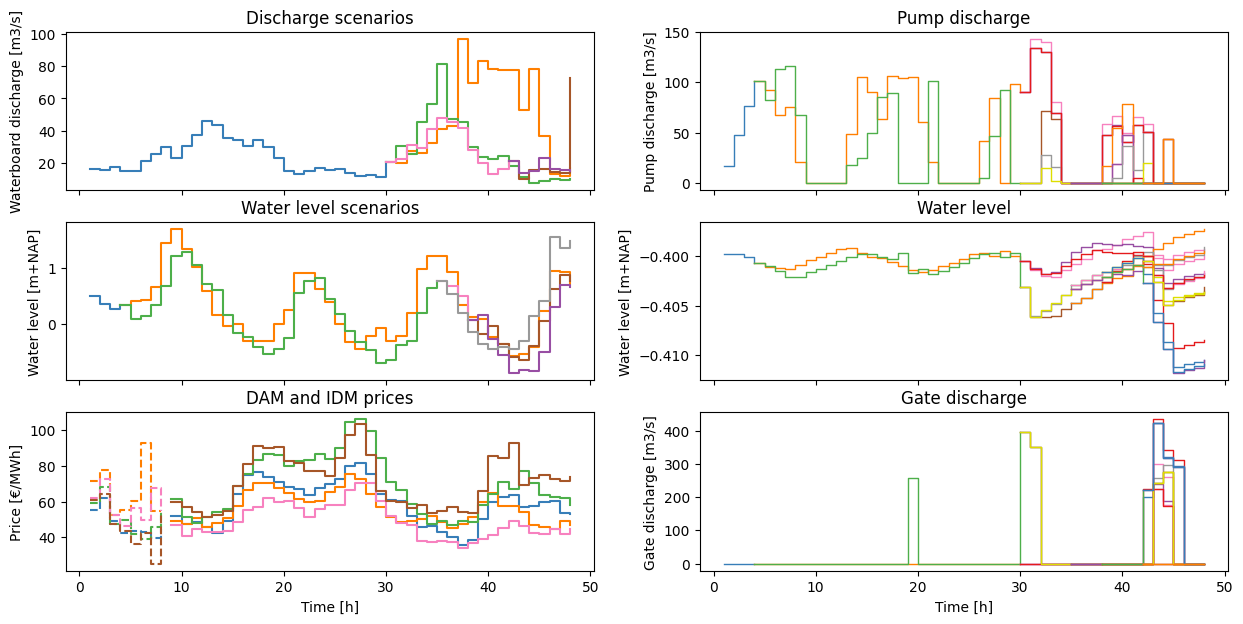

In [75]:
fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
# Inputs on the left
plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
ax[0,0].set_title('Discharge scenarios')
ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
ax[1,0].set_title('Water level scenarios')
ax[1,0].set_ylabel('Water level [m+NAP]')


# IDM prices
idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
    ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

# DAM prices
dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
    ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

ax[2,0].set_title('DAM and IDM prices')
ax[2,0].set_ylabel('Price [€/MWh]')
ax[2,0].set_xlabel('Time [h]')

# Outputs on the right
plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
ax[0,1].set_title('Pump discharge')
ax[0,1].set_ylabel('Pump discharge [m3/s]')

plot_res(ax[1,1], 'h_nzk', results, cb_colorlist)
ax[1,1].set_title('Water level')
ax[1,1].set_ylabel('Water level [m+NAP]')

plot_res(ax[2,1], 'q_gate', results, cb_colorlist)
ax[2,1].set_title('Gate discharge')
ax[2,1].set_ylabel('Gate discharge [m3/s]')
ax[2,1].set_xlabel('Time [h]')


Text(0.5, 0, 'Time [h]')

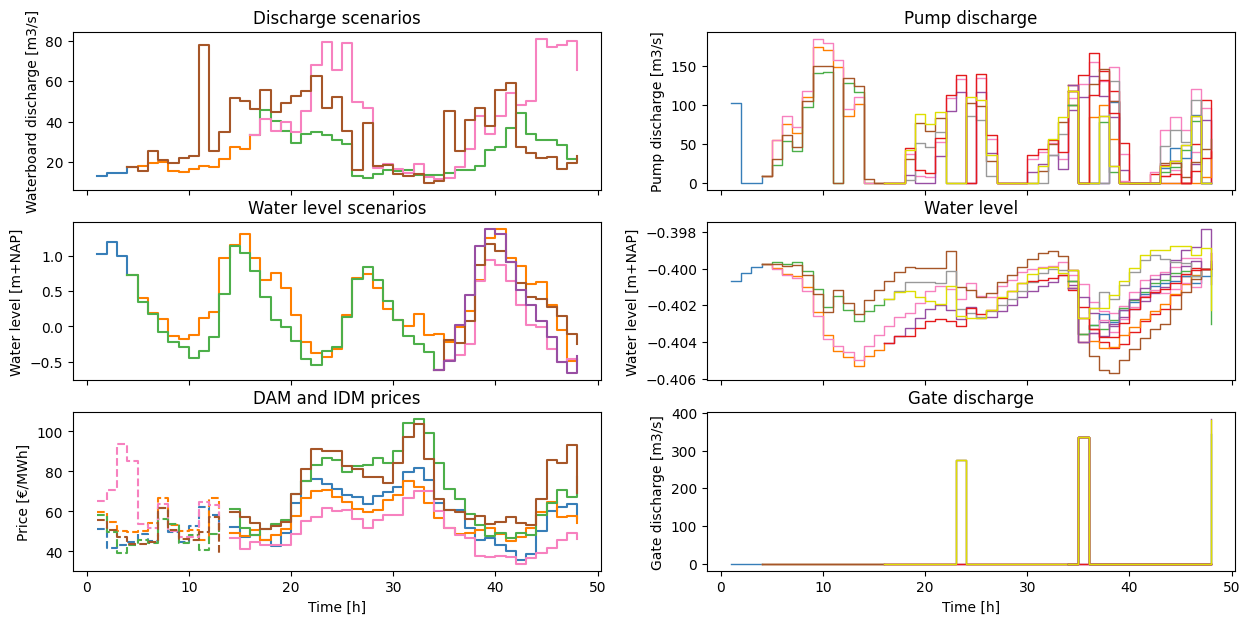

In [62]:
fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
# Inputs on the left
plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
ax[0,0].set_title('Discharge scenarios')
ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
ax[1,0].set_title('Water level scenarios')
ax[1,0].set_ylabel('Water level [m+NAP]')


# IDM prices
idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
    ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

# DAM prices
dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
    ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

ax[2,0].set_title('DAM and IDM prices')
ax[2,0].set_ylabel('Price [€/MWh]')
ax[2,0].set_xlabel('Time [h]')

# Outputs on the right
plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
ax[0,1].set_title('Pump discharge')
ax[0,1].set_ylabel('Pump discharge [m3/s]')

plot_res(ax[1,1], 'h_nzk', results, cb_colorlist)
ax[1,1].set_title('Water level')
ax[1,1].set_ylabel('Water level [m+NAP]')

plot_res(ax[2,1], 'q_gate', results, cb_colorlist)
ax[2,1].set_title('Gate discharge')
ax[2,1].set_ylabel('Gate discharge [m3/s]')
ax[2,1].set_xlabel('Time [h]')


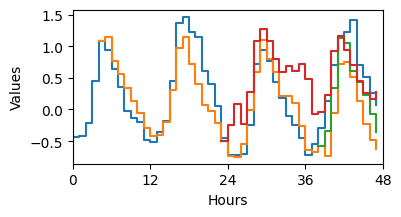

In [145]:
data_dict['wl'][1].plot_tree()

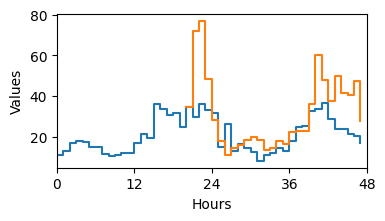

In [204]:
data_dict['wb_discharge'][1].plot_tree()

In [114]:
n = NodesEdges(data_dict['wb_discharge'][1])

IndexError: list index out of range

In [111]:
data_dict['probabilities']

{'dam': array([0.171, 0.199, 0.219, 0.169, 0.243]),
 'idm': array([0.276, 0.191, 0.157, 0.145, 0.231])}

In [98]:
data_dict['E_dam']

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: nan,
 15: nan,
 16: nan,
 17: nan,
 18: nan,
 19: nan,
 20: nan,
 21: nan,
 22: nan,
 23: nan,
 24: nan,
 25: nan,
 26: nan,
 27: nan,
 28: nan,
 29: nan,
 30: nan,
 31: nan,
 32: nan,
 33: nan,
 34: nan,
 35: nan,
 36: nan,
 37: nan,
 38: nan,
 39: nan,
 40: nan,
 41: nan,
 42: nan,
 43: nan,
 44: nan,
 45: nan,
 46: nan,
 47: nan,
 48: nan}

In [29]:
t = data_dict['wb_discharge'][1]
t

Node: 0, Scenarios: [0, 1, 2], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [0, 1], Weight: 0.7, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        Node: 0, Scenarios: [0], Weight: 0.51, Domain: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
        Node: 1, Scenarios: [1], Weight: 0.49, Domain: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
    Node: 1, Scenarios: [2], Weight: 0.3, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

In [30]:
print(len(t[1].edge_values), len(t[1].domain))

44 44


In [58]:
tree = NodesEdges(t)

In [61]:
tree.nodes

[Node 0 with domain [0, 1, 2, 3], values [13.1  14.75 14.52 17.57] and probability 1,
 Node 1 with domain [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], values [18.14 19.61 20.18 15.87 15.42 16.81 18.36 17.65 21.52 27.7  26.74 33.64] and probability 0.7,
 Node 2 with domain [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], values [45.84 40.19 35.22 29.61 34.19 35.14 33.57 31.07 29.07 13.17 12.22 14.18
  15.96 15.9  16.31 13.92 13.57 13.64 14.66 16.08 15.99 17.91 26.13 27.57
  37.02 44.09 33.92 31.22 30.74 28.59 21.52 21.48] and probability 0.51,
 Node 3 with domain [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], values [41.44       35.44       39.79       34.77       45.24       68.23
  79.36333333 65.66       78.88333333 49.57       46.84       17.02
  19.03       16.6        14.75       19.26       12.65       11.92
  12.19    

In [59]:
# Get the observations of the external variables at t_now-1h (so one timestep )
t_o = t_now - pd.DateOffset(hours=1)
dam_o, idm_o, wl_hourly_o, discharge_o, ark_o = obs_data.get_observation_data(start=t_o, end=t_o)

# Get the observations of h_nzk at t_now-1h (so one timestep )
# We need to get the h_nzk at t_now-1h, because we need to know the state of the system to decide control actions
# So we decide the control action from t_now:t_now+control_horizon
# h_nzk_o = self.simulation_data.loc[t_o, 'h_nzk']

In [16]:
# Get the current DAM prices (observed) untill the next DAM price
dam_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour+1), freq='H', periods=25) # 25 because we need the DAM price of the hour before this day as well
dam_obs = obs_data.get_observation_data_single('DAM', dam_obs_index[0], dam_obs_index[-1])

# Get the IDM scenarios untill now (observed)
idm_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), t_now - pd.DateOffset(hours=1), freq='H')
idm_obs = obs_data.get_observation_data_single('IDM', idm_obs_index[0], idm_obs_index[-1])

# Get the IDM scenarios untill the DAM (forecast / generated)
idm_scens = idm_scenarios(dam_obs.values.flatten(), idm_obs.values.flatten(), 10)

In [17]:
idm_scens

,0,1,2,3,4,5,6,7,8,9,10,11,12,weight
0,59.148744,58.259121,54.498564,50.794329,56.597205,65.014513,81.281174,61.193835,46.774566,44.596588,41.697673,45.402658,50.680677,0.178938
1,23.618979,32.744027,24.480164,39.25793,43.4434,37.127978,29.355777,37.894065,42.166573,47.7792,56.707884,65.2717,51.522431,0.148486
2,51.788912,51.460857,47.349044,43.362443,45.385374,41.44504,59.643247,52.263292,44.084745,49.34747,50.786366,60.032111,56.271556,0.238336
3,52.022769,44.250502,45.921293,49.502229,48.011079,50.643628,56.57963,49.540464,49.086553,47.345455,48.053835,42.822531,45.660182,0.239201
4,62.590786,57.073922,52.779782,48.463151,48.011079,54.822747,60.431976,51.426848,48.996495,48.130672,51.184141,60.032111,39.916448,0.195039


In [18]:
wl_scens = scenario_data.get_scenarios(t_now, 'wl').copy()

# Now divide all the columns except the last (weights) by 100 to convert from cm+NAP to m+NAP
wl_scens.iloc[:, :-1] = wl_scens.iloc[:, :-1] / 100
wl_scens

WL +1   WL +2   WL +3   WL +4   WL +5  \
date                      scenario                                           
2019-01-01 11:00:00+01:00 0         1.1299  1.2460  0.9243  0.5203  0.2110   
                          1         1.0249  1.1908  0.9969  0.7288  0.4067   
                          2         1.0844  1.2714  0.9875  0.5710  0.3485   
                          3         0.9104  1.0883  0.9632  0.6934  0.3423   
                          4         1.1254  1.2979  1.0394  0.6791  0.3790   

                                     WL +6   WL +7   WL +8   WL +9  WL +10  \
date                      scenario                                           
2019-01-01 11:00:00+01:00 0        -0.0069 -0.1571 -0.3617 -0.5111 -0.4300   
                          1         0.1877  0.1095 -0.1300 -0.1853 -0.1232   
                          2         0.1790 -0.0728 -0.2217 -0.2900 -0.4426   
                          3         0.2791  0.2347 -0.0981 -0.1639 -0.3881   
                          4         0.1593  0.0742 -0.1377 -0.3744 -0.1830   

                                    ...  WL +40  WL +41  WL +42  WL +43  \
date                      scenario  ...                                   
2019-01-01 11:00:00+01:00 0         ...  0.5655  0.2876 -0.0351 -0.2367   
                          1         ...  1.3782  0.9725  0.8600  0.6021   
                          2         ...  0.8700  0.6440  0.3050  0.0260   
                          3         ...  1.0690  0.9131  0.6138  0.4227   
                          4         ...  1.3074  0.9131  0.5157  0.3095   

                                    WL +44  WL +45  WL +46  WL +47  WL +48  \
date                      scenario                                           
2019-01-01 11:00:00+01:00 0        -0.3006 -0.3951 -0.5602 -0.6445 -0.5964   
                          1         0.6317  0.3068 -0.0485 -0.4879 -0.4629   
                          2        -0.0027 -0.3205 -0.4990 -0.4638 -0.5510   
                          3         0.3903  0.2702  0.1457 -0.1073 -0.2438   
                          4         0.0705 -0.1528 -0.5071 -0.6644 -0.4243   

                                     weights  
date                      scenario            
2019-01-01 11:00:00+01:00 0         0.174824  
                          1         0.161927  
                          2         0.244318  
                          3         0.172699  
                          4         0.246232  

[5 rows x 49 columns]

In [19]:
scenario_data.generate_tree(t_now, 'wl', scenarios=wl_scens)

[0, 4, 33, 47] [1, 1, 2, 4]


Node: 0, Scenarios: [0, 1, 2, 3], Weight: 1, Domain: [0, 1, 2, 3, 4]
    Node: 0, Scenarios: [0], Weight: 0.23, Domain: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
    Node: 1, Scenarios: [1, 2, 3], Weight: 0.77, Domain: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
        Node: 0, Scenarios: [1], Weight: 0.28, Domain: [34 35 36 37 38 39 40 41 42 43 44 45 46 47]
        Node: 1, Scenarios: [2], Weight: 0.42, Domain: [34 35 36 37 38 39 40 41 42 43 44 45 46 47]
        Node: 2, Scenarios: [3], Weight: 0.3, Domain: [34 35 36 37 38 39 40 41 42 43 44 45 46 47]

In [20]:
# Get the DAM scenarios for tomorrow -> DA bid and prep
next_dam_timestep = t_now + pd.DateOffset(hours=24-t_now.hour)
dam_scenarios = scenario_data.get_scenarios(next_dam_timestep, 'DAM').copy()
# dam_scenarios = dam_scenarios.iloc[:, :-idm_scens.shape[1]] # Remove the DAM scenarios begin the pred hor
dam_scenarios = dam_scenarios.iloc[:, [i for i in range(48 - (idm_scens.shape[1] - 1))] + [-1]]
dam_scenarios

DAM NL +1  DAM NL +2  DAM NL +3  \
date                      scenario                                    
2019-01-02 00:00:00+01:00 0             52.13      47.39      48.39   
                          1             49.37      47.76      50.68   
                          2             61.25      51.53      48.29   
                          3             46.78      40.99      44.96   
                          4             59.75      57.17      54.16   

                                    DAM NL +4  DAM NL +5  DAM NL +6  \
date                      scenario                                    
2019-01-02 00:00:00+01:00 0             45.94      42.71      49.00   
                          1             45.65      47.99      51.07   
                          2             51.16      53.97      55.78   
                          3             43.00      43.08      43.42   
                          4             51.44      52.63      54.93   

                                    DAM NL +7  DAM NL +8  DAM NL +9  \
date                      scenario                                    
2019-01-02 00:00:00+01:00 0             64.06      75.00      76.43   
                          1             57.68      66.50      70.29   
                          2             68.70      75.37      83.41   
                          3             48.53      55.39      56.98   
                          4             68.96      81.05      91.39   

                                    DAM NL +10  ...  DAM NL +27  DAM NL +28  \
date                      scenario              ...                           
2019-01-02 00:00:00+01:00 0              73.54  ...       43.00       40.30   
                          1              70.60  ...       48.70       45.14   
                          2              86.73  ...       49.28       46.72   
                          3              61.91  ...       37.87       37.38   
                          4              90.21  ...       54.92       57.23   

                                    DAM NL +29  DAM NL +30  DAM NL +31  \
date                      scenario                                       
2019-01-02 00:00:00+01:00 0              35.91       38.64       50.01   
                          1              47.29       51.64       59.92   
                          2              49.33       48.35       58.14   
                          3              33.98       36.72       39.26   
                          4              54.21       53.37       65.99   

                                    DAM NL +32  DAM NL +33  DAM NL +34  \
date                      scenario                                       
2019-01-02 00:00:00+01:00 0              59.99       62.39       63.92   
                          1              64.64       57.35       57.66   
                          2              64.43       70.82       67.22   
                          3              41.53       45.49       49.06   
                          4              85.62       84.24       92.96   

                                    DAM NL +35   weights  
date                      scenario                        
2019-01-02 00:00:00+01:00 0              56.96  0.170581  
                          1              53.98  0.199018  
                          2              77.24  0.218939  
                          3              46.48  0.168587  
                          4              69.35  0.242874  

[5 rows x 36 columns]

In [21]:
discharge_scenarios = scenario_data.get_scenarios(t_now, 'discharge').copy()
discharge_scenarios

Q +1   Q +2   Q +3   Q +4   Q +5   Q +6  \
date                      scenario                                             
2019-01-01 11:00:00+01:00 0         13.10  14.75  14.52  17.57  18.14  19.61   
                          1         10.22   9.96  12.44  15.55  13.52  15.40   
                          2          8.40   9.37  11.36  14.85  14.02  14.66   
                          3          9.17  11.58  16.46  19.29  23.40  26.75   
                          4          8.62   9.42  12.07  16.67  15.77  25.64   

                                     Q +7   Q +8   Q +9  Q +10  ...  Q +40  \
date                      scenario                              ...          
2019-01-01 11:00:00+01:00 0         20.18  15.87  15.42  16.81  ...  27.57   
                          1         13.22  10.44  11.24  10.59  ...  43.00   
                          2         13.30  11.99  11.58  11.95  ...  27.91   
                          3         20.27  17.75  14.61  21.98  ...  38.43   
                          4         20.97  19.50  22.05  22.89  ...  55.52   

                                    Q +41  Q +42  Q +43      Q +44      Q +45  \
date                      scenario                                              
2019-01-01 11:00:00+01:00 0         37.02  44.09  33.92  31.220000  30.740000   
                          1         54.23  48.13  50.33  80.883333  76.883333   
                          2         36.23  33.25  24.57  15.100000   8.320000   
                          3         29.72  42.62  26.09  32.790000  21.230000   
                          4         59.30  27.37  24.67  22.120000  22.630000   

                                        Q +46      Q +47  Q +48   weights  
date                      scenario                                         
2019-01-01 11:00:00+01:00 0         28.590000  21.520000  21.48  0.207833  
                          1         77.713333  79.803333  65.74  0.201182  
                          2          9.830000   9.380000   9.95  0.173321  
                          3         20.280000  25.770000  28.08  0.183757  
                          4         16.800000  19.860000  23.20  0.233907  

[5 rows x 49 columns]

In [22]:
scenario_data.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)

[0, 3, 15, 47] [1, 1, 2, 3]


Node: 0, Scenarios: [0, 1, 2], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [0, 1], Weight: 0.7, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        Node: 0, Scenarios: [0], Weight: 0.51, Domain: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47]
        Node: 1, Scenarios: [1], Weight: 0.49, Domain: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47]
    Node: 1, Scenarios: [2], Weight: 0.3, Domain: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]

In [53]:
scenario_data.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)

Node: 0, Scenarios: [0, 1, 2], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [0, 1], Weight: 0.7, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        Node: 0, Scenarios: [0], Weight: 0.51, Domain: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
        Node: 1, Scenarios: [1], Weight: 0.49, Domain: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 1, Scenarios: [2], Weight: 0.3, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]

In [53]:
# Generate the simulation index
t_min = max([df.index.min() for df in [obs_data.dam, obs_data.idm, obs_data.wl, obs_data.discharge, obs_data.ark]]) + pd.DateOffset(days=1, hours=11)

,DAM
2019-01-01 00:00:00+01:00,68.92
2019-01-01 01:00:00+01:00,64.98
2019-01-01 02:00:00+01:00,60.27
2019-01-01 03:00:00+01:00,49.97
2019-01-01 04:00:00+01:00,47.66
2019-01-01 05:00:00+01:00,48.00
2019-01-01 06:00:00+01:00,49.75
2019-01-01 07:00:00+01:00,55.12
2019-01-01 08:00:00+01:00,44.80
2019-01-01 09:00:00+01:00,49.58


In [ ]:
idm_scenarios()

In [37]:
scen_data = ScenarioData(scenario_params)

In [35]:
scen_data.discharge.index

MultiIndex([('2019-01-01 01:00:00+01:00', 0),
            ('2019-01-01 01:00:00+01:00', 1),
            ('2019-01-01 01:00:00+01:00', 2),
            ('2019-01-01 01:00:00+01:00', 3),
            ('2019-01-01 01:00:00+01:00', 4),
            ('2019-01-01 02:00:00+01:00', 0),
            ('2019-01-01 02:00:00+01:00', 1),
            ('2019-01-01 02:00:00+01:00', 2),
            ('2019-01-01 02:00:00+01:00', 3),
            ('2019-01-01 02:00:00+01:00', 4),
            ...
            ('2019-08-09 21:00:00+02:00', 0),
            ('2019-08-09 21:00:00+02:00', 1),
            ('2019-08-09 21:00:00+02:00', 2),
            ('2019-08-09 21:00:00+02:00', 3),
            ('2019-08-09 21:00:00+02:00', 4),
            ('2019-08-09 22:00:00+02:00', 0),
            ('2019-08-09 22:00:00+02:00', 1),
            ('2019-08-09 22:00:00+02:00', 2),
            ('2019-08-09 22:00:00+02:00', 3),
            ('2019-08-09 22:00:00+02:00', 4)],
           names=['date', 'scenario'], length=26505)

In [23]:
damdates = scen_data.dam.index.get_level_values(0).unique()
dam_scens = scen_data.dam.index.get_level_values(1).unique()
damdates = damdates.tz_convert('Europe/Amsterdam')


In [24]:
damdates

DatetimeIndex(['2019-01-01 01:00:00+01:00', '2019-01-02 01:00:00+01:00',
               '2019-01-03 01:00:00+01:00', '2019-01-04 01:00:00+01:00',
               '2019-01-05 01:00:00+01:00', '2019-01-06 01:00:00+01:00',
               '2019-01-07 01:00:00+01:00', '2019-01-08 01:00:00+01:00',
               '2019-01-09 01:00:00+01:00', '2019-01-10 01:00:00+01:00',
               ...
               '2019-07-31 02:00:00+02:00', '2019-08-01 02:00:00+02:00',
               '2019-08-02 02:00:00+02:00', '2019-08-03 02:00:00+02:00',
               '2019-08-04 02:00:00+02:00', '2019-08-05 02:00:00+02:00',
               '2019-08-06 02:00:00+02:00', '2019-08-07 02:00:00+02:00',
               '2019-08-08 02:00:00+02:00', '2019-08-09 02:00:00+02:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', name='date', length=221, freq=None)

In [25]:
pd.date_range(damdates[0] - pd.DateOffset(hours=1), freq='1D', periods=len(damdates))

DatetimeIndex(['2019-01-01 00:00:00+01:00', '2019-01-02 00:00:00+01:00',
               '2019-01-03 00:00:00+01:00', '2019-01-04 00:00:00+01:00',
               '2019-01-05 00:00:00+01:00', '2019-01-06 00:00:00+01:00',
               '2019-01-07 00:00:00+01:00', '2019-01-08 00:00:00+01:00',
               '2019-01-09 00:00:00+01:00', '2019-01-10 00:00:00+01:00',
               ...
               '2019-07-31 00:00:00+02:00', '2019-08-01 00:00:00+02:00',
               '2019-08-02 00:00:00+02:00', '2019-08-03 00:00:00+02:00',
               '2019-08-04 00:00:00+02:00', '2019-08-05 00:00:00+02:00',
               '2019-08-06 00:00:00+02:00', '2019-08-07 00:00:00+02:00',
               '2019-08-08 00:00:00+02:00', '2019-08-09 00:00:00+02:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=221, freq='D')

In [11]:
t0 = obs_data.dam.index[10]
obs_data.dam.loc[t0:t0]

,DAM
2019-01-01 10:00:00+01:00,55.44


In [7]:
scenarios = {}
for varname in ['DAM', 'wl']:
    scenarios[varname] = pd.read_pickle(scenario_path / f'{varname}_{scenario_params[varname]["method"]}_{scenario_params[varname]["n"]}.pkl').dropna()

scenarios['discharge'] = pd.read_pickle(scenario_path / f'discharge_{scenario_params["discharge"]["method"]}_{scenario_params["discharge"]["n"]}_{scenario_params["discharge"]["n"]}.pkl').dropna()

In [8]:
scenario_gen = ScenarioData(scenario_params, constrain_tree_complexity=True, complexity_reduction=0.5)

In [9]:
date = scenario_gen.wl.index[0][0]

In [10]:
scen = scenario_gen.get_scenarios(date, 'wl')
scen.index = scen.index.droplevel(0)
scen

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
scenario,,,,,,,,,,,,,,,,,,,,,
0,100.09,90.81,64.24,54.31,26.03,-22.43,-36.52,-23.80,6.73,27.64,...,78.38,11.90,-26.91,-45.63,-62.64,-70.85,-38.70,23.69,118.19,0.142058
1,76.30,52.18,31.14,4.37,-13.37,-28.15,-55.08,-36.83,-13.06,27.61,...,6.93,-29.91,-36.45,-40.74,-48.64,-63.77,-54.99,-33.31,11.61,0.232424
2,87.15,64.56,40.51,18.53,13.12,-11.71,-26.15,-15.10,19.36,53.95,...,45.48,81.76,72.26,14.29,14.80,-1.59,-4.33,16.33,94.80,0.251484
3,86.69,64.35,54.00,38.51,14.50,-8.93,-16.73,-22.38,-4.74,20.63,...,-3.68,-21.76,-29.51,-37.49,-56.94,-63.77,-64.22,-1.63,72.41,0.188475
4,76.91,50.12,27.55,19.74,-8.28,-32.46,-30.63,-25.19,-21.25,26.74,...,-12.45,-0.51,2.46,0.88,3.05,-5.78,16.50,107.87,129.36,0.185559


In [14]:
wltree = scenario_gen.generate_tree(date, 'discharge')

In [15]:
wltree

Node: 0, Scenarios: [0, 1, 2, 3], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [1, 0, 2], Weight: 0.79, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
        Node: 0, Scenarios: [1, 0], Weight: 0.66, Domain: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
            Node: 0, Scenarios: [0], Weight: 0.49, Domain: [44, 45, 46, 47, 47]
            Node: 1, Scenarios: [1], Weight: 0.51, Domain: [44, 45, 46, 47, 47]
        Node: 1, Scenarios: [2], Weight: 0.34, Domain: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 1, Scenarios: [3], Weight: 0.21, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]

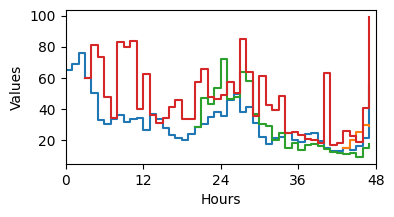

In [16]:
wltree.plot_tree()